In [141]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
import json
from IPython.display import display as disp
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import subprocess

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

# Plot decision tree

Make a decision tree plot for the report

In [11]:
data_path = '../../allan_data/DataPredictMovement_half.p'
x, y = np.load(data_path)
x = x
xx_tr = x[:8000, :]
yy_tr = y[:8000] 

In [210]:
graphs = list()
for name, depth, max_leaf_nodes in [('shallow', 2, 8), ('deep', 16, 60)]:
    tree = DecisionTreeClassifier(max_depth=depth, class_weight=None,
                                  criterion='entropy', max_leaf_nodes=max_leaf_nodes) 

    tree.fit(xx_tr, yy_tr)

    columns = [f"{cha}_{qrt}" for cha in "Call SMS GPS Bluetooth".split() for qrt in range(1, 9)] 

    dot_data = export_graphviz(tree, out_file=None, feature_names=columns, class_names=["Didn't move", "Did move"],
                               filled=True, impurity=True, leaves_parallel=True, rounded=True,
                               special_characters=True)
    dot_data = dot_data.replace('helvetica', '"CMU Sans Serif"') 
    with open(f'decision_tree_example_{name}.dot', 'w') as fid:
        fid.write(dot_data)

    graphs.append(graphviz.Source(dot_data))

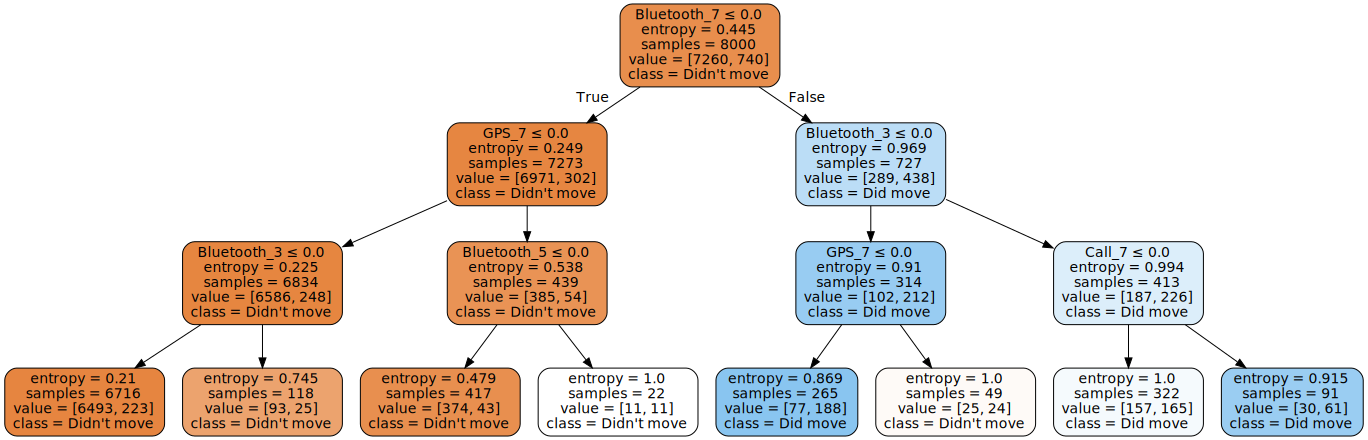

In [211]:
graphs[0]

In [212]:
print(subprocess.call(
     'dot -Tpdf decision_tree_example_shallow.dot -o figs/decision_tree_example_shallow.pdf',
      shell=True))
print(subprocess.call(
     'dot -Tpdf decision_tree_example_deep.dot  -o figs/decision_tree_example_deep.pdf',
      shell=True)) 

0
0


In [84]:
with open('userMovement_rf_coarse.pkl', 'br') as fid:
    rfc = pickle.load(fid)
with open('userMovement_rf_finer.pkl', 'br') as fid:
    rff = pickle.load(fid)

In [85]:
rfc.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [24]:
rfc.validation_auc_score

0.8589634875117511

In [25]:
rfc.best_score_

0.8584558041362306

In [26]:
rfc.validation_auc_score - rfc.best_score_

0.0005076833755205401

In [27]:
est = rfc.best_estimator_.steps[1][1] 

In [28]:
est.feature_importances_.shape

(32,)

In [29]:
tr0 = est.estimators_[0]
columns = [f"{cha}{qrt}" for cha in "csgb" for qrt in range(1, 9)]
feature_importance = np.zeros((len(est.estimators_), len(tr0.feature_importances_)))
for i, tr in enumerate(est.estimators_):
    feature_importance[i, :] = tr.feature_importances_ 
fi = pd.DataFrame(feature_importance, columns=columns)

In [30]:
fi = fi[fi.mean().sort_values(ascending=False).index] * 100

In [31]:
fi.head() 

,b7,b3,g7,g3,s7,...,c6,s5,s1,c5,c1
0,44.911739,35.679640,0.976231,1.277292,1.337043,...,0.254748,0.172246,0.279923,0.171319,0.181755
1,77.268876,2.934542,2.970511,0.707058,0.798130,...,0.249481,0.196723,0.159604,0.162971,0.181244
2,75.404045,4.641294,2.561013,2.451872,0.564517,...,0.298924,0.180989,0.173417,0.176871,0.152236
3,52.733662,33.823561,0.718640,1.674308,0.695750,...,0.220801,0.222329,0.176601,0.183128,0.201160
4,80.813430,3.792741,1.388992,2.500923,0.651349,...,0.198659,0.179466,0.188586,0.184450,0.172293


In [12]:
cat_dct = {'b': 0.0, 'c': 1.0, 'g': 2.0, 's': 3.0} 
cat = pd.Series(fi.columns.str[0].map(lambda s: cat_dct[s]), index=fi.columns) 

In [13]:
fi_agg = pd.DataFrame([fi.mean(), fi.std(), cat], index=['Feature importance', 'std', 'cat']).T

fi_agg.head() 

,Feature importance,std,cat
b7,60.635047,15.640734,0.0
b3,14.030777,12.831086,0.0
g7,5.376852,5.762392,2.0
g3,3.488555,4.171598,2.0
s7,1.740810,2.083635,3.0


/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


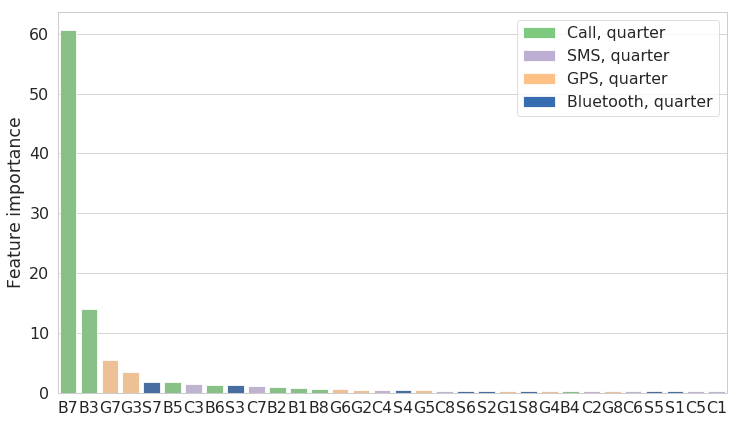

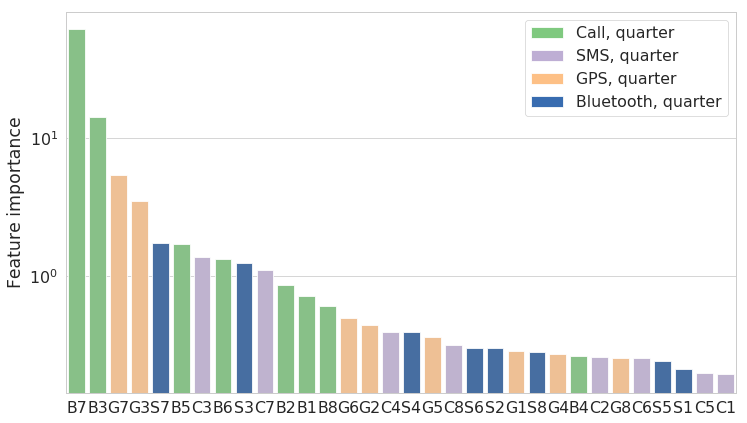

In [17]:
for log_switch in [False, True]:
    fig, ax = plt.subplots()
    bars = sns.barplot(data=fi_agg, y='Feature importance', x=fi_agg.index,
                       hue='cat', dodge=False, ax=ax, log=log_switch)
    custom_lines = [mpl.patches.Patch(facecolor=colorcycle[0]),
                    mpl.patches.Patch(facecolor=colorcycle[1]),
                    mpl.patches.Patch(facecolor=colorcycle[2]),
                    mpl.patches.Patch(facecolor=colorcycle[3])]
    ax.legend(custom_lines, ["Call, quarter", "SMS, quarter", "GPS, quarter",
                             "Bluetooth, quarter"], loc="upper right")
    ax.set_xticklabels(el.get_text().upper() for el in ax.get_xticklabels());
    if log_switch:
        fig.savefig('figs/random_forest_important_features_logarithmic.pdf')
    else:
        fig.savefig('figs/random_forest_important_features_linear.pdf')

Text(0,0.5,'Tree')

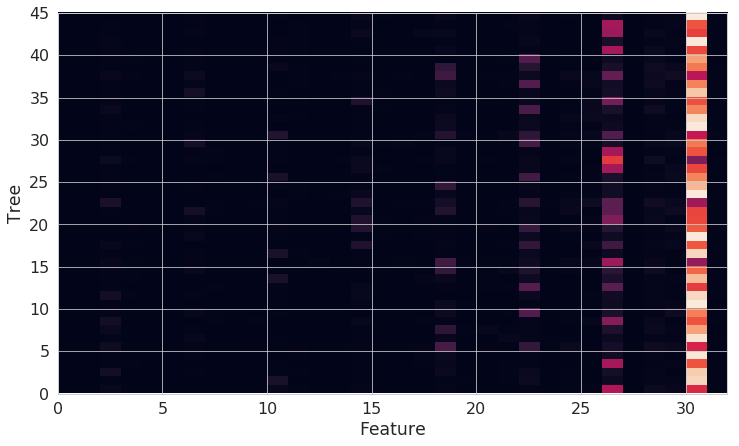

In [18]:
fig, ax = plt.subplots()
ax.pcolorfast(feature_importance)
ax.set_xlabel('Feature')
ax.set_ylabel('Tree')

In [20]:
tr0.tree_.node_count

31331

In [21]:
n_tree_nodes = np.array([tr.tree_.node_count for tr in est.estimators_])

Text(0,0.5,'# trees')

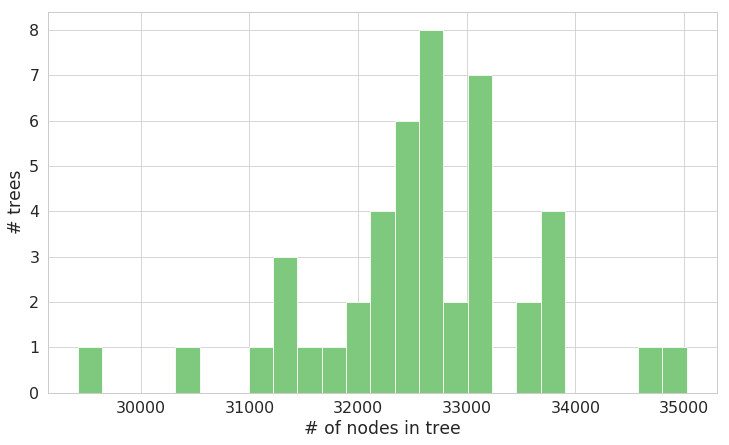

In [29]:
fig, ax = plt.subplots()
ax.hist(n_tree_nodes, 25)
ax.set_xlabel("# of nodes in tree")
ax.set_ylabel("# trees")

In [33]:
kw_rx = re.compile(r'(?P<key>\S+) = (?P<value>.+)')
op_rx = re.compile(r'(?P<key>\S+) (?P<operator>\S=) (?P<value>.+)')
ed_rx = re.compile(r'^(\d+) -> (\d+)') 

In [34]:
x_rx = re.compile(r'X\[(\d{1,2})\]')

def parse_label(label):
    m = x_rx.search(label)
    if m:
        return int(m.groups()[0]) 
    return None

In [87]:
def tree2nxgraph(tr):
    dot_file = export_graphviz(tr, out_file=None)
    nodes, edges = list(), list()
    for line in dot_file.split('\n'):
        try:
            if '[label=' in line:
                start = line.find('"') + 1
                end = line.find('"', start)
                lbl = line[start:end]
                nodes.append((int(line.split(' ', maxsplit=1)[0]), parse_label(lbl)))
                continue
            elif '->' in line:
                a, b = ed_rx.search(line).groups()
                edges.append((int(a), int(b)))
            else:
                print("Didn't read", repr(line))
        except:  # noqa
            print(line)
    g = nx.DiGraph()
    for nid, attr in nodes:
        g.add_node(nid, nodeattr=attr)
    g.add_edges_from(edges)
    return g, nodes

# Calling function with first tree

In [131]:
def tree_stat_summary(g, nodes):
    outdeg_arr     = np.array(g.out_degree)
    outdeg_count   = pd.value_counts(outdeg_arr[:, 1])
    node_splits    = outdeg_arr[(outdeg_arr[:, 1] == 2), 0]
    dist_from_root = [nx.shortest_path_length(g, 0, nd) for nd in node_splits]


    nodeattr  = nx.get_node_attributes(g, 'nodeattr')
    splits    = np.array(nodes)[:, 1]
    splits_vc = pd.value_counts(splits, dropna=False)

    narr = np.array(nodes)
    narr_vc = pd.value_counts(narr[:, 1])

    root_distance = np.zeros((16, 32), dtype=int)
    rootdf = list()
    for i, (nd, sv) in enumerate(((nd, sv) for (nd, sv) in nodes if g.out_degree[nd] == 2)):
        dst = nx.shortest_path_length(g, 0, nd)
        root_distance[dst, sv] += 1
        rootdf.append((nd, sv, dst))
    rootdf = pd.DataFrame(rootdf, columns="node variable distance".split())
    return outdeg_count, dist_from_root, splits_vc, root_distance, rootdf



Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Didn't read '}'
Didn't read 'digraph Tree {'
Didn't read 'node [shape=box] ;'
Di

IndexError: list index out of range

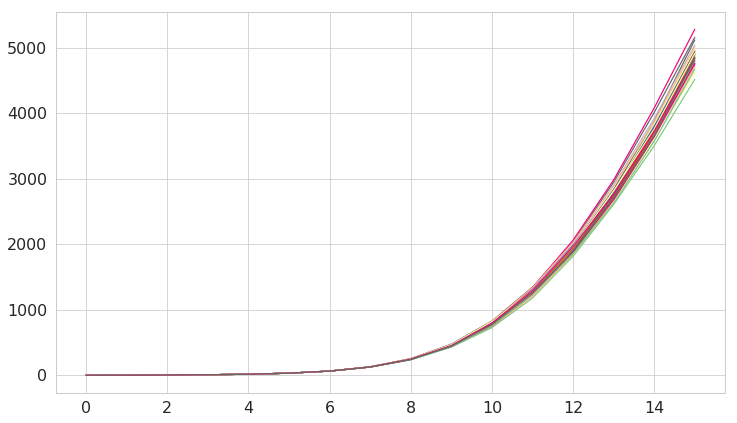

In [138]:
root_distance_agg = np.zeros((16, 32))
splits_vc_agg = pd.Series(index=list(range(32)) + [np.NaN])
dist_from_root_agg = list()
fig, ax = plt.subplots()
for tr in est.estimators_:
    g, nodes = tree2nxgraph(tr)
    
    outdeg_count, dist_from_root, splits_vc, root_distance, rootdf = tree_stat_summary(g, nodes) 
    
    root_distance_agg += root_distance
    splits_vc_agg += splits_vc 
    dist_from_root_agg.append(dist_from_root)

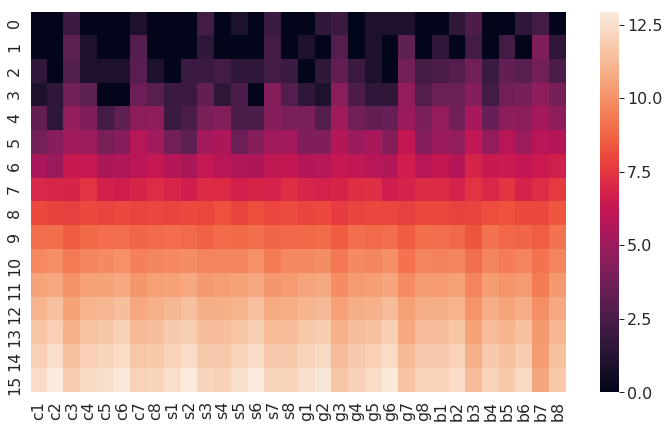

In [145]:
fig, ax = plt.subplots()
sns.heatmap(data=np.log2(root_distance_agg + 1))
ax.set_xticks(np.arange(32) + 0.5)
ax.set_xticklabels(columns); 

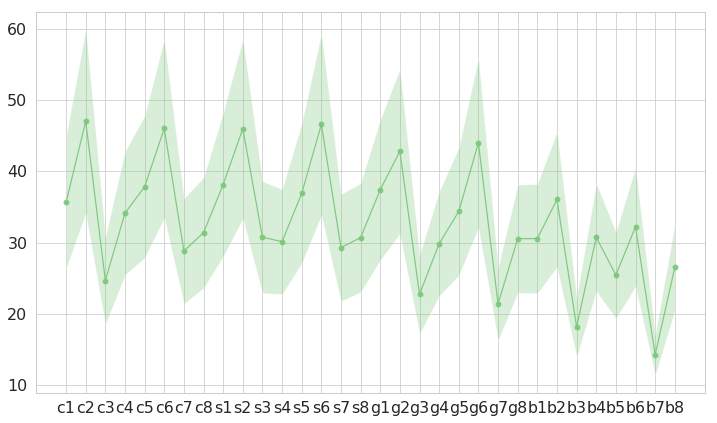

In [150]:
fig, ax = plt.subplots()
x = np.arange(root_distance_agg.shape[1])
y = root_distance_agg.mean(axis=0)/32
std = root_distance_agg.std(axis=0)/np.sqrt(32)/32
ax.fill_between(x, y-std, y+std, alpha=0.3)
ax.plot(x, y, '-o')
ax.set_xticks(np.arange(32))
ax.set_xticklabels(columns); 

In [124]:
def tree_stat_summary(g, nodes):
    outdeg_arr     = np.array(g.out_degree)
    outdeg_count   = pd.value_counts(outdeg_arr[:, 1])
    node_splits    = outdeg_arr[(outdeg_arr[:, 1] == 2), 0]
    dist_from_root = [nx.shortest_path_length(g, 0, nd) for nd in node_splits]


    nodeattr  = nx.get_node_attributes(g, 'nodeattr')
    splits    = np.array(nodes)[:, 1]
    splits_vc = pd.value_counts(splits, dropna=False)

    narr = np.array(nodes)
    narr_vc = pd.value_counts(narr[:, 1])

    root_distance = np.zeros((16, 32), dtype=int)
    rootdf = list()
    for i, (nd, sv) in enumerate(((nd, sv) for (nd, sv) in nodes if g.out_degree[nd] == 2)):
        dst = nx.shortest_path_length(g, 0, nd)
        root_distance[dst, sv] += 1
        rootdf.append((nd, sv, dst))
    rootdf = pd.DataFrame(rootdf, columns="node variable distance".split())
    return outdeg_count, dist_from_root, splits_vc, root_distance, rootdf


outdeg_count, dist_from_root, splits_vc, root_distance, rootdf = tree_stat_summary(g, nodes) 

In [125]:
print(outdeg_count) 

0    15666
2    15665
dtype: int64


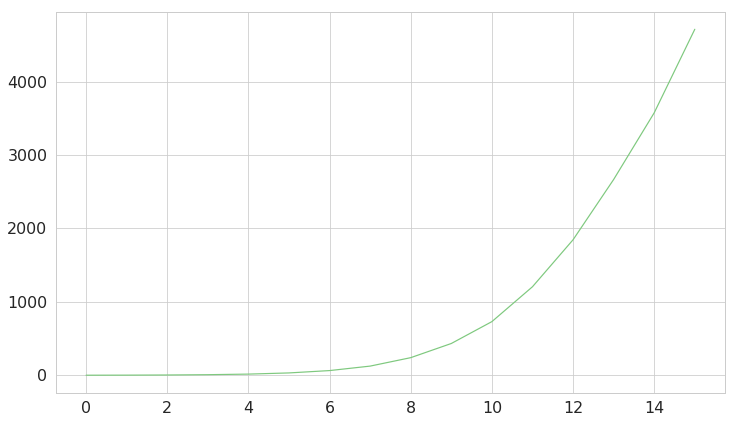

In [116]:
fig, ax = plt.subplots()
plt.plot(pd.value_counts(dist_from_root)[::-1]) 

In [126]:
print(splits_vc)

NaN      15666
 17.0      726
 5.0       717
 9.0       717
 1.0       700
 13.0      677
 21.0      651
 25.0      630
 3.0       584
 16.0      572
 18.0      571
 22.0      555
 0.0       528
 19.0      520
 8.0       519
 11.0      512
 4.0       508
 24.0      507
 12.0      482
 29.0      475
 20.0      457
 10.0      444
 7.0       429
 15.0      424
 6.0       422
 14.0      401
 30.0      392
 27.0      384
 23.0      375
 2.0       363
 31.0      217
 28.0      205
 26.0        1
dtype: int64


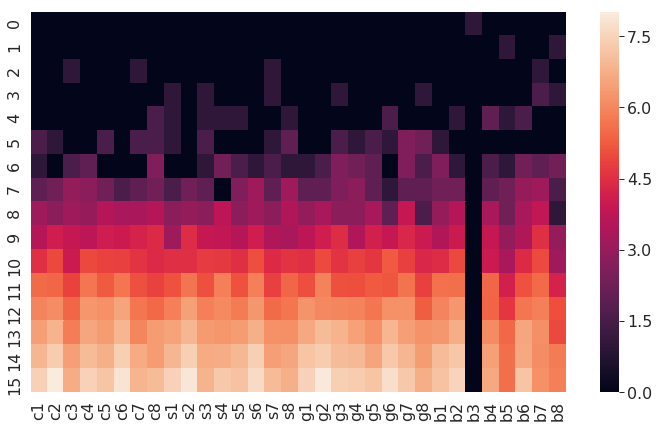

In [128]:
fig, ax = plt.subplots()
sns.heatmap(data=np.log2(root_distance + 1))
ax.set_xticks(np.arange(32) + 0.5)
ax.set_xticklabels(columns); 

In [130]:
x.shape, y.shape

((32,), (32,))

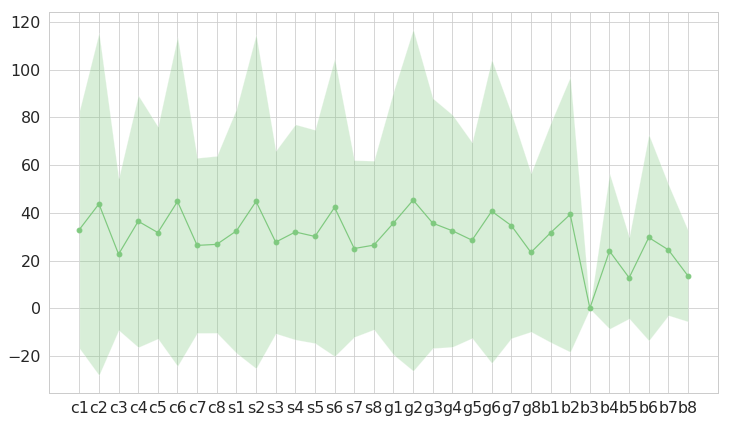

In [129]:
fig, ax = plt.subplots()
x = np.arange(root_distance.shape[1])
y = root_distance.mean(axis=0)
std = root_distance.std(axis=0)
ax.fill_between(x, y-std, y+std, alpha=0.3)
ax.plot(x, y, '-o')
ax.set_xticks(np.arange(32))
ax.set_xticklabels(columns); 